# Examine SST Tendency $T_T$ 

In [35]:
# imports
import os
import numpy as np

import h5py

import matplotlib as mpl
import matplotlib.gridspec as gridspec
from matplotlib import pyplot as plt

import seaborn as sns

from ulmo.plotting import plotting
from ulmo import io as ulmo_io

# Four panel fig

In [106]:
def orig_four_panel(FS_img, TT_img, SST_img, med_ratio=1.759375e-11,
              FS_thresh=1e-14):
    fig = plt.figure(figsize=(12,10))
    plt.clf()
    gs = gridspec.GridSpec(2, 2)
    
    # F_S
    ax = plt.subplot(gs[0])
    scl_FS = FS_img / med_ratio
    amx = max(np.max(np.abs(scl_FS)), 
        np.max(np.abs(TT_img)))
    plotting.show_image(scl_FS, ax=ax,
                       vmnx=(-amx, amx),
                       cm='seismic')
    
    # TT
    ax = plt.subplot(gs[1])
    plotting.show_image(TT_img, ax=ax,
                       vmnx=(-amx, amx),
                       cm='seismic')
    
    # % difference
    ax = plt.subplot(gs[2])
    high_FS = FS_img > FS_thresh
    #r_img = FS_img/TT_img/med_ratio
    #r_img[~high_FS] = 0.
    #p_diff = (FS_thresh - TT_img*med_ratio)/FS_thresh
    p_diff = np.log10(FS_thresh) - np.log10(TT_img*med_ratio)
    p_diff[~high_FS] = np.nan
    plotting.show_image(p_diff, ax=ax,
                       vmnx=(-1, 1.),
                       cm='PuOr')
    
    # SST
    ax = plt.subplot(gs[3])
    plotting.show_image(SST_img, ax=ax)

    plt.show()

# Load up

In [13]:
FS_tbl = ulmo_io.load_main_table('s3://llc/Tables/LLC_FS_r0.5A.parquet')

Read main table: s3://llc/Tables/LLC_FS_r0.5A.parquet


In [77]:
FS_file = os.path.join(os.getenv('OS_OGCM'), 'LLC', 'F_S', 'PreProc',
                       'LLC_FS_preproc_Fs.h5')
TT_file = os.path.join(os.getenv('OS_OGCM'), 'LLC', 'F_S', 'PreProc',
                       'LLC_FS_preproc_T_SST.h5')

SST_file = os.path.join(os.getenv('OS_OGCM'), 'LLC', 'F_S', 'PreProc',
                       'LLC_FS_preproc.h5')

In [82]:
f_SST = h5py.File(SST_file, 'r')

In [26]:
f_FS = h5py.File(FS_file, 'r')
f_TT = h5py.File(TT_file, 'r')
print(f_FS['valid'].shape, f_TT['valid'].shape)
nimg = f_FS['valid'].shape[0]

(1425660, 1, 64, 64) (1425660, 1, 64, 64)


# Need a baseline - Examine ratio of 10,000 images above a FS threshold ($10^{-15}$)

## Random selection

In [27]:
irand = np.random.choice(np.arange(nimg), size=10000, replace=False)

In [29]:
r_FS = f_FS['valid'][np.sort(irand), 0, ...]

In [30]:
r_TT = f_TT['valid'][np.sort(irand), 0, ...]

In [32]:
r_ratio = r_FS / r_TT
r_ratio.shape

/tmp/ipykernel_1305789/2654812671.py:1: RuntimeWarning: divide by zero encountered in divide
  r_ratio = r_FS / r_TT
/tmp/ipykernel_1305789/2654812671.py:1: RuntimeWarning: invalid value encountered in divide
  r_ratio = r_FS / r_TT


(10000, 64, 64)

In [126]:
gd_FS = r_FS > 1e-14
gd_FS.shape

(10000, 64, 64)

In [127]:
gd_ratio = r_ratio[gd_FS]

In [128]:
gd_ratio.size

86186

In [129]:
gd_ratio

array([1.0488367e-11, 1.0690345e-11, 9.6631227e-12, ..., 2.7753496e-11,
       2.6320418e-11, 2.7467183e-11], dtype=float32)

## Plot

/tmp/ipykernel_1305789/2472576049.py:1: RuntimeWarning: invalid value encountered in log10
  sns.histplot(np.log10(gd_ratio), bins=50)


<Axes: ylabel='Count'>

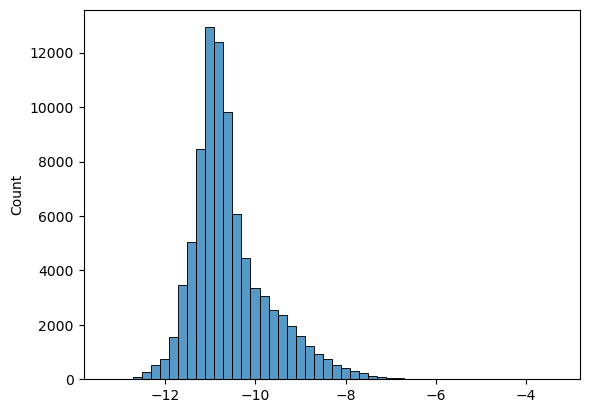

In [130]:
sns.histplot(np.log10(gd_ratio), bins=50)

/tmp/ipykernel_1305789/971848238.py:1: RuntimeWarning: invalid value encountered in log10
  sns.displot(x=np.log10(r_FS[gd_FS]), y=np.log10(gd_ratio))


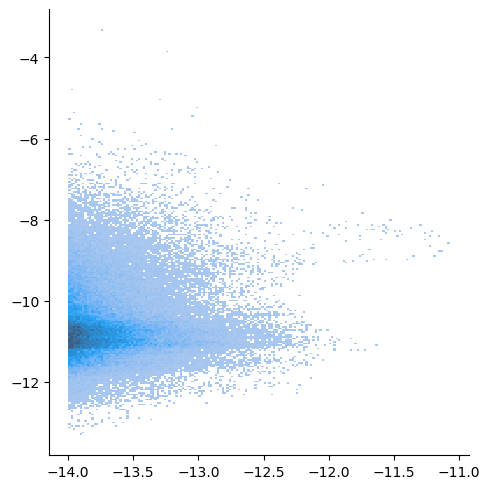

In [131]:
sns.displot(x=np.log10(r_FS[gd_FS]), y=np.log10(gd_ratio))

In [44]:
med_rtio = np.median(gd_ratio)
med_rtio

1.759375e-11

# Let's examine a few

/tmp/ipykernel_1305789/1928745782.py:28: RuntimeWarning: invalid value encountered in log10
  p_diff = np.log10(FS_thresh) - np.log10(TT_img*med_ratio)


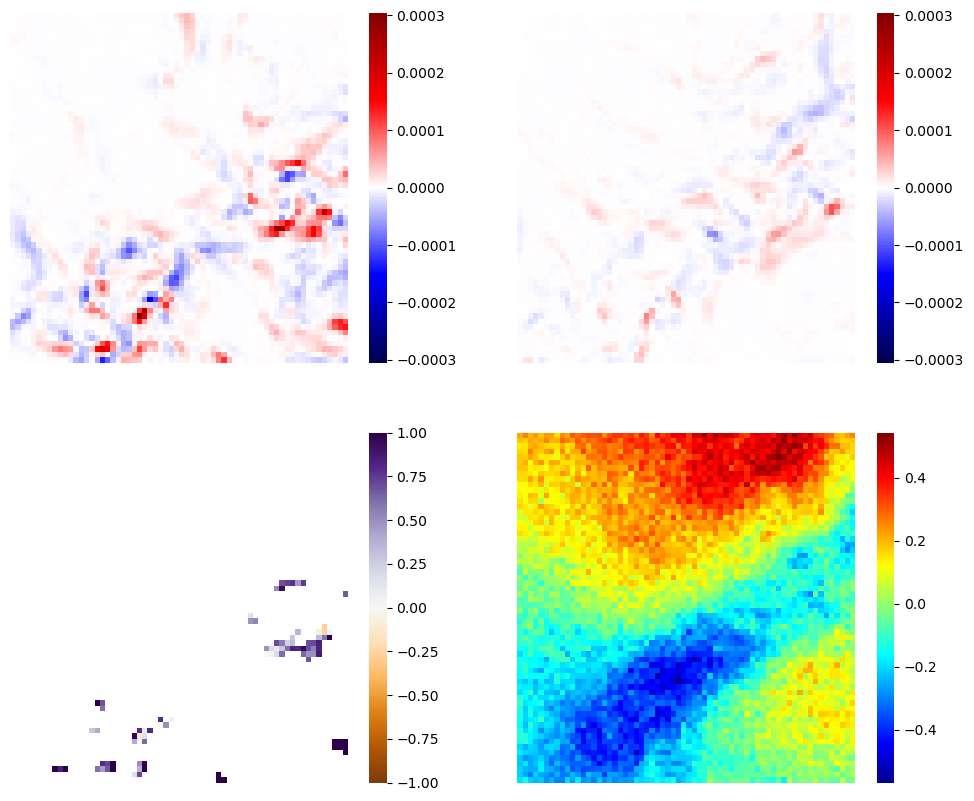

In [83]:
idx = 25000
FS_img = f_FS['valid'][idx, 0, ...]
TT_img = f_TT['valid'][idx, 0, ...]
SST_img = f_SST['valid'][idx, 0, ...]
four_panel(FS_img, TT_img, SST_img)

## Larger $F_S$

In [101]:
high_NPos = np.where(FS_tbl.FS_Npos.fillna(0).values > 100)[0]
high_NPos

array([   3856,    5684,    5920, ..., 1484054, 1484055, 1484538])

In [134]:
FS_tbl.iloc[high_NPos[2]]

lat                                                         43.800121
lon                                                         -55.96875
row                                                             10427
col                                                             16385
datetime                                          2011-09-30 00:00:00
filename            /data/Projects/Oceanography/data/LLC/ThetaUVSa...
pp_file                            s3://llc/PreProc/LLC_FS_preproc.h5
pp_root                                                        llc_FS
field_size                                                         64
pp_idx                                                         659329
pp_type                                                             0
mean_temperature                                            17.002367
Tmin                                                           14.095
Tmax                                                        18.498001
T90                 

In [138]:
def pos_four_panel(FS_img, TT_img, SST_img, med_ratio=1.759375e-11,
              FS_thresh=1e-14):
    fig = plt.figure(figsize=(12,10))
    plt.clf()
    gs = gridspec.GridSpec(2, 2)
    
    # F_S
    ax = plt.subplot(gs[0])
    plotting.show_image(np.log10(FS_img), ax=ax,
                       vmnx=(-15, -12),
                       cm='Blues')
    
    # TT
    ax = plt.subplot(gs[1])
    plotting.show_image(np.log10(TT_img*med_ratio), ax=ax,
                       vmnx=(-15, -12),
                       cm='Greens')
    
    # % difference
    ax = plt.subplot(gs[2])
    high_FS = FS_img > FS_thresh
    #r_img = FS_img/TT_img/med_ratio
    #r_img[~high_FS] = 0.
    #p_diff = (FS_thresh - TT_img*med_ratio)/FS_thresh
    p_diff = np.log10(FS_img) - np.log10(TT_img*med_ratio)
    p_diff[~high_FS] = np.nan
    plotting.show_image(p_diff, ax=ax,
                       vmnx=(-1, 1.),
                       cm='PuOr')
    
    # SST
    ax = plt.subplot(gs[3])
    plotting.show_image(SST_img, ax=ax)

    plt.show()

/tmp/ipykernel_1305789/555833194.py:9: RuntimeWarning: invalid value encountered in log10
  plotting.show_image(np.log10(FS_img), ax=ax,
/tmp/ipykernel_1305789/555833194.py:15: RuntimeWarning: invalid value encountered in log10
  plotting.show_image(np.log10(TT_img*med_ratio), ax=ax,
/tmp/ipykernel_1305789/555833194.py:25: RuntimeWarning: invalid value encountered in log10
  p_diff = np.log10(FS_img) - np.log10(TT_img*med_ratio)


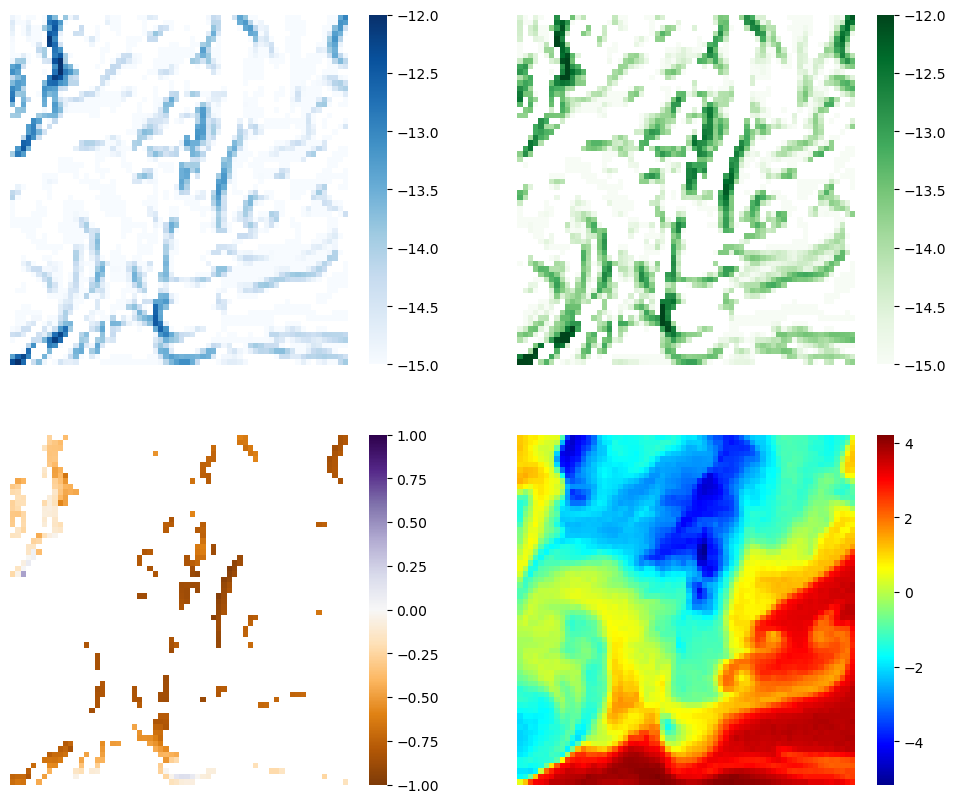

In [141]:
idx = 885673 
#idx = 1032910
#idx = 659329
FS_img = f_FS['valid'][idx, 0, ...]
TT_img = f_TT['valid'][idx, 0, ...]
SST_img = f_SST['valid'][idx, 0, ...]
pos_four_panel(FS_img, TT_img, SST_img)